# Counting, proofreading and visualizing inputs and outputs

This notebook requires an environment where the python <a href="https://navis.readthedocs.io/en/latest/" target="_blank">navis</a> and <a href="https://fafbseg-py.readthedocs.io/en/latest/source/api.html" target="_blank">fafbseq</a> packages are installed, apart from other well-known packages listed in the import below.
<br>**CONTAINS:**
<br>A) Analysis of inputs and ouputs based on *cleft score* value
<br>B) Analysis of inputs and outputs of a list of neurons
<br>C) Proofreading predicted synapses via annotations
<br>D) Calculating and plotting synaptic cleft size ditribution between partners 
<br>E) Checking the existance of IDs from Codex in our data base 
<br>F) Updating your IDs
<br>G) Plotting our Tm9 patches / clusters
<br>H) Tm9-patch mining

#### Importing packages

In [2]:
#Importing packages
import navis
import fafbseg
from fafbseg import flywire
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from caveclient import CAVEclient
from visualizations.helpers.synapse_queries import combine_xyz, separate_xyz, synapse_count

client = CAVEclient('flywire_fafb_production')

#### Setting a "secret" for accessing data

To get your personal secret, please go to: <a href="https://fafbseg-py.readthedocs.io/en/latest/source/tutorials/flywire_secret.html" target="_blank">get my secret.</a>

In [ ]:
# fafbseg.flywire.set_chunkedgraph_secret("5719b2db462d94d6aa0e903c1ff889e4") # 2022.03.11
# fafbseg.flywire.set_chunkedgraph_secret("c161f679dd3d52b1d5fc19f62cdd0164") # 2022.04.11 
fafbseg.flywire.set_chunkedgraph_secret("0c0edb71c5682a971dbadc37bcbabf29") # 2022.06.21 

## A) Analysis of inputs and ouputs based on *cleft score* value

To automatically detect of pre- and postsynaptic sites, the algorithm used in <a href="https://www.nature.com/articles/s41592-021-01183-7" target="_blank">Buhman et al. 2021.</a>
<br>A visualization of all predicted synapses can visualized by Neuroglancer <a href="http://www.tinyurl.com/tdq6xkw" target="_blank">here.</a>
<br>The algorithm returns a list of connections with two scores: the cleft score and the connection score. Number of detected synapses depend on them.

<font size="4"> The *cleft score* matters, the *connection score* not that much:</font> <br/>
<span style="color:blue">&emsp;&emsp;&emsp;&emsp;&emsp;&emsp; True positives </span> <br/>
<span style="color:Chocolate">&emsp;&emsp;&emsp;&emsp;&emsp;&emsp; False positives </span> <br/>
<span style="color:DimGrey">&emsp;&emsp;&emsp;&emsp;&emsp;&emsp; Unkown </span> <br/>


<img src="./Images/proofreading/szi-chieh_labels_synapse_eval_cleft_score.png" 
     alt="cleft_score"
     width="300" height="300" style="float: left ; width: 40%; padding-left: 10%"/>
<img src="./Images/proofreading/szi-chieh_labels_synapse_eval_synful_score.png" 
     alt="connection_score"
     width="300" height="300" style="float: left ; width: 40%; padding-left: 0%"/>



### Testing different cleft score values in Tm9 inputs

In the following cells, we choose different *cleft score* values to get the total number of inputs and outputs of a single Tm9.

In [ ]:
#Getting inputs and outputs for one neuron with different min_score values

# FIRST, Check if root IDs are outdated (i.e. have more recent edits)
r1 = 720575940626482442 # root ID query for Tm9
print(f'ID up-to-date in FlyWire: {flywire.is_latest_root([r1])}')
# SECOND, proceed getting the neurons data if the ID is up to date
if flywire.is_latest_root([r1])[0]:
    neuron = flywire.get_mesh_neuron(r1) # mesh query
else:
    print(f'ID not up to date. Update it and run again')

# THIRD, proceed getting the neuron's inputs and outputs for a list of different min_scores 
# “Cleft score” for automatic synaptic detection, Buhmann et al., 2021
if flywire.is_latest_root([r1])[0]:
    min_score_ls = [0,10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180]
    in_count_ls =[]
    out_count_ls =[]
    pre_count_ls=[]
    post_count_ls=[]
    
    for score in min_score_ls:
        # Fetch the neuron's inputs and ouputs
        inputs = flywire.synapses.fetch_synapses(neuron, pre=False, post=True, attach=True, 
                                                 min_score=score, clean=True, transmitters=False, 
                                                 neuropils=True, live_query=True, batch_size=30, 
                                                 dataset='production', progress=True)
        outputs = flywire.synapses.fetch_synapses(neuron, pre=True, post=False, attach=True, 
                                                 min_score=score, clean=True, transmitters=False, 
                                                 neuropils=True, live_query=True, batch_size=30, 
                                                 dataset='production', progress=True)
        
        # Counting inputs and ouputs per ID
        inputs_count = {}
        inputs_str = inputs.applymap(str)
        for c in inputs_str['pre'].to_list():
            inputs_count[c] = inputs_count.get(c, 0) + 1
        input_count_df = pd.DataFrame(inputs_count, index=[0])
        input_count_df = input_count_df.T
        input_count_df.rename(columns={0: "counts"},inplace=True)
        input_count_df.index.names = ['presynaptic_ID']
        input_count_df['postsynaptic_ID'] = inputs_str['post'].to_list()[0:len(input_count_df)]
        

        outputs_count = {}
        outputs_str = outputs.applymap(str)
        for c in outputs_str['post'].to_list():
            outputs_count[c] = outputs_count.get(c, 0) + 1
        output_count_df = pd.DataFrame(outputs_count, index=[0])
        output_count_df = output_count_df.T
        output_count_df.rename(columns={0: "counts"},inplace=True)
        output_count_df.index.names = ['postsynaptic_ID']
        output_count_df['presynaptic_ID'] = outputs_str['pre'].to_list()[0:len(output_count_df)]
        
        #Storing useful info during the for-loop
        in_count_ls.append(input_count_df['counts'].sum())
        out_count_ls.append(output_count_df['counts'].sum())
        pre_count_ls.append(len(input_count_df.index))
        post_count_ls.append(len(output_count_df.index))
        
        # Printing useful info
        #print(f"Current score = {score}")
        #print(f"Total number of inputs = {input_count_df['counts'].sum()}")
        #print(f"Total number of outputs = {output_count_df['counts'].sum()}")
        #print(f"Total number of presynaptic partners = {len(input_count_df.index)}")
        #print(f"Total number of postsynaptic partners = {len(output_count_df.index)}")

Let's now creat a pandas dataframe with the obtain lists and then generate some line plots.

In [ ]:
#Generation of pandas dataframe from lists
cleft_score_df = pd.DataFrame(list(zip(min_score_ls, in_count_ls, out_count_ls, pre_count_ls, post_count_ls)),
               columns =['Cleft_scores', 'input_count', 'output_count','pre_partner_count', 'post_partner_count'])
#print(cleft_score_df)

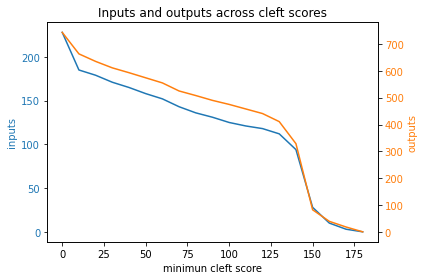

In [41]:
#Plotting
fig, ax1 = plt.subplots()
color = 'tab:blue'
ax1.plot(cleft_score_df['Cleft_scores'],cleft_score_df['input_count'], color=color)
    ax1.set_ylabel('inputs', color=color) 
    ax1.set_title('Inputs and outputs across cleft scores')
    ax1.set_xlabel('minimun cleft score')
    ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:orange'
ax2.set_ylabel('outputs', color=color)  
ax2.plot(cleft_score_df['Cleft_scores'],cleft_score_df['output_count'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [ ]:
# Saving excel files
# Setting variable
outDir = r'Z:\Connectomics data\FlyWire\Excels\min_score_50'
save_excel_file = False

if save_excel_file: 
    ## Inputs
    file_name = str(neuron.id)+'_inputs.xlsx'
    savePath = os.path.join(outDir, file_name)
    inputs_str = inputs.applymap(str)
    inputs_str.to_excel(savePath)

    file_name = str(neuron.id)+'_inputs_count.xlsx'
    savePath = os.path.join(outDir, file_name)
    input_count_str_df = input_count_df.applymap(str)
    input_count_str_df.to_excel(savePath)


    ## Outputs
    file_name = str(neuron.id)+'_outputs.xlsx'
    savePath = os.path.join(outDir, file_name)
    outputs_str = outputs.applymap(str)
    outputs_str.to_excel(savePath)

    file_name = str(neuron.id)+'_outputs_count.xlsx'
    savePath = os.path.join(outDir, file_name)
    output_count_str_df = output_count_df.applymap(str)
    output_count_str_df.to_excel(savePath)

## B) Analysis of inputs and outputs of a list of neurons

### 1. Loading IDs manually

In [13]:
# Check if root IDs are outdated (i.e. have more recent edits)
# Selecting Neurons
curr_ID_ls = [720575940622355226]   # your query

print(f'ID up-to-date in FlyWire: {flywire.is_latest_root(curr_ID_ls)}')

ID up-to-date in FlyWire: [ True]


In [11]:
np.unique(flywire.is_latest_root(curr_ID_ls))

array([False])

#### 1.1 Cheking connectivity of not-up-to-date segments

In [9]:
if not np.unique(flywire.is_latest_root(curr_ID_ls))[0]: #if not up-to-date
    # Fetch the neuron's inputs and outputs
    neurons_inputs = flywire.synapses.fetch_synapses(curr_ID_ls, pre=False, post=True, attach=True, 
                                             min_score=50, clean=True, transmitters=False, 
                                             neuropils=True, batch_size=30, 
                                             dataset='production', progress=True) #,mat= "live"
    neurons_outputs = flywire.synapses.fetch_synapses(curr_ID_ls, pre=True, post=False, attach=True, 
                                             min_score=50, clean=True, transmitters=False, 
                                             neuropils=True, batch_size=30, 
                                             dataset='production', progress=True) #, mat= "live"


Using materialization version 526
Using materialization version 526


### 1. Or, loading from excel file

In [2]:
# Choose path and file
import os

dataPath = r'D:\Connectomics data\FlyWire\Excels'
dataPath = r'C:\Users\sebas\Downloads'
fileDate = '20230110'
fileName = f'Tm9 proofreadings_{fileDate}.xlsx'
fileName = f'Tm1 proofreadings_{fileDate}.xlsx'
filePath = os.path.join(dataPath,fileName)

In [4]:
df = pd.read_excel(filePath)
curr_ID_ls = df["seg_id"].tolist()

In [18]:
# Applying any filter?
filtered_df = df[(df['twigs proofread (Y/N)']== 'Y') & (df['inputs_proofread (Y/N)']!= 'Y') & (df['cluster_id']!= -1)& (df['cluster_id']!= 3)].copy()
print(len(filtered_df))

# Defining id to work with
curr_ID_ls = filtered_df["seg_id"].tolist()

17


### 1. Or, loading from txt file

In [3]:
# Choose path and file
import os

dataPath = r'D:\Connectomics-Data\FlyWire\Txts\inputs_proofread'
fileDate = '20230614'
fileName = f'root_ids_Tm9_left_optic_lobe_inputs_proofread_20230614.txt'
filePath = os.path.join(dataPath,fileName)
ids_df = pd.read_csv(filePath, sep = ",")
curr_ID_ls = ids_df.columns.tolist()

### 2. Updating IDs and fetching synapses

In [4]:
#Updating the IDs via Fafbseg
updated_ID_df = fafbseg.flywire.update_ids(curr_ID_ls, stop_layer=2, supervoxels=None, timestamp=None, dataset='production', progress=True)

Updating:   0%|          | 0/249 [00:00<?, ?it/s]

In [5]:
# Fetching synapses from new IDs
ID_ls = updated_ID_df["new_id"].tolist()

if np.unique(flywire.is_latest_root(ID_ls))[0]:
    # Fetch the neuron's inputs and putputs
    neurons_inputs = flywire.synapses.fetch_synapses(ID_ls, pre=False, post=True, attach=True, 
                                             min_score=50, clean=True, transmitters=False, 
                                             neuropils=True, batch_size=30, 
                                             dataset='production', progress=True,mat= "live")
    neurons_outputs = flywire.synapses.fetch_synapses(ID_ls, pre=True, post=False, attach=True, 
                                             min_score=50, clean=True, transmitters=False, 
                                             neuropils=True, batch_size=30, 
                                             dataset='production', progress=True, mat= "live")
    #synaptic_counts = flywire.synapses.synapse_counts(root_ids, by_neuropil=False, min_score=30, live_query=True,batch_size=10, dataset='production')
else:
    print(f'IDs not up to date, analysis aborted') 
    

Fetching synapses:   0%|          | 0/9 [00:00<?, ?it/s]

Fetching synapses:   0%|          | 0/9 [00:00<?, ?it/s]

#### Selecting a neuropile of interest for synaptic counts per neuron ID

In [9]:
neurons_inputs.head()

,id,created,superceded_id,valid,pre_x,pre_y,pre_z,post_x,post_y,post_z,...,glut,oct,ser,da,valid_nt,pre_pt_supervoxel_id,pre,post_pt_supervoxel_id,post,neuropil
0,1421728,2021-03-09 20:14:58.183080+00:00,NaN,t,349688,310292,198520,349712,310196,198560,...,0.527560,3.641458e-03,6.727068e-03,0.035544,t,76636373377341677,720575940425301947,76636373377350573,720575940635543220,LO_R
1,5449369,2021-03-09 20:14:58.183080+00:00,NaN,t,262760,300436,168960,262792,300544,168960,...,0.001686,1.456605e-07,1.863760e-08,0.000003,t,75158423523760792,720575940639494965,75158423523761985,720575940605651302,ME_R
4,18384914,2021-03-09 20:14:58.183080+00:00,NaN,t,265600,301624,166560,265472,301684,166520,...,0.000196,4.731417e-08,3.786213e-08,0.000002,t,75158492243159694,720575940639494965,75158492243165895,720575940605651302,ME_R
5,161901881,2021-03-09 20:14:58.183080+00:00,NaN,t,262428,299712,169960,262360,299584,169960,...,0.010218,3.397282e-02,4.548533e-03,0.004352,t,75158423523794001,720575940626214437,75158423523796784,720575940605651302,ME_R
6,161904116,2021-03-09 20:14:58.183080+00:00,NaN,t,268892,300536,170360,268784,300448,170320,...,0.007527,1.548539e-04,8.288060e-07,0.000055,t,75228792268004316,720575940639494965,75228792267997689,720575940605651302,ME_R


In [10]:
# Selecting inputs from a single neuropile
neuropile = ['ME_R','ME_R'] # String. 'LO_R', 'ME_R', ...
#or
neuropile_list = ['ME_R','LO_R']

neuropile_neurons_inputs = neurons_inputs[(neurons_inputs['neuropil'].isin(neuropile_list))]
no_neuropile_neurons_inputs = neurons_inputs[~(neurons_inputs['neuropil'].isin(neuropile))]


### 2.1. For all inputs

In [11]:
# LOOPING. Counting inputs and ouputs per ID, option joining dataframes
final_input_df = pd.DataFrame()
for n in neurons_inputs['post'].unique():
    inputs_count = {}
    curr_inputs = neurons_inputs[neurons_inputs['post'] == n]
    inputs_str = curr_inputs.applymap(str)
    
    for c in inputs_str['pre'].to_list():
        inputs_count[c] = inputs_count.get(c, 0) + 1
    input_count_df = pd.DataFrame(inputs_count, index=[0])
    input_count_df = input_count_df.T
    input_count_df.rename(columns={0: "counts"},inplace=True)
    input_count_df.index.names = ['presynaptic_ID']
    input_count_df = input_count_df.sort_values(by="counts",ascending=False)
    input_count_df['postsynaptic_ID'] = inputs_str['post'].to_list()[0:len(input_count_df)]
    final_input_df = final_input_df.append(input_count_df)
    #print(f'Counting done for: {n}')
input_count_str_df = final_input_df.applymap(str)
input_count_str_df.head()

,counts,postsynaptic_ID
presynaptic_ID,,
720575940644993992,32,720575940635543220
720575940645260910,8,720575940635543220
720575940661086337,6,720575940635543220
720575940639559357,6,720575940635543220
720575940604721120,5,720575940635543220


### 2.2 Or, for a selection of all inputs.

In [22]:
# LOOPING. Counting inputs and ouputs per ID, option joining dataframes
#For "no_neuropile_neurons_inputs"

final_input_df = pd.DataFrame()
for n in no_neuropile_neurons_inputs['post'].unique():
    inputs_count = {}
    curr_inputs = no_neuropile_neurons_inputs[no_neuropile_neurons_inputs['post'] == n]
    inputs_str = curr_inputs.applymap(str)
    
    for c in inputs_str['pre'].to_list():
        inputs_count[c] = inputs_count.get(c, 0) + 1
    input_count_df = pd.DataFrame(inputs_count, index=[0])
    input_count_df = input_count_df.T
    input_count_df.rename(columns={0: "counts"},inplace=True)
    input_count_df.index.names = ['presynaptic_ID']
    input_count_df = input_count_df.sort_values(by="counts",ascending=False)
    input_count_df['postsynaptic_ID'] = inputs_str['post'].to_list()[0:len(input_count_df)]
    final_input_df = final_input_df.append(input_count_df)
    #print(f'Counting done for: {n}')
input_count_str_df = final_input_df.applymap(str)
input_count_str_df.head()

,counts,postsynaptic_ID
presynaptic_ID,,
720575940644993992,32,720575940635543220
720575940629922245,2,720575940635543220
720575940425301947,1,720575940635543220
720575940621064128,1,720575940635543220
720575940644993992,18,720575940629938298


### 3. Adding useful information to the dataframe

In [23]:
#Updating the IDs via Fafbseg
presynaptic_ID = input_count_str_df.index.tolist()
updated_ID_df = fafbseg.flywire.update_ids(presynaptic_ID, stop_layer=2, supervoxels=None, timestamp=None, dataset='production', progress=True)

presynaptic_ID_ls = updated_ID_df["new_id"].tolist()

Updating:   0%|          | 0/2165 [00:00<?, ?it/s]

In [24]:
# Identifying user-based annotations about cell identity

identification_df = flywire.find_celltypes(presynaptic_ID_ls, user=None, exact=False, case=False, regex=True, update_roots=False)
identification_no_duplicates_df = identification_df.drop_duplicates(subset='pt_root_id', keep='first', inplace=False, ignore_index=False).copy()

In [25]:
identification_no_duplicates_df

,id,created,superceded_id,pt_position_x,pt_position_y,pt_position_z,tag,user_id,pt_supervoxel_id,pt_root_id
196,197,2022-02-07 04:55:10.125086+00:00,NaN,491220,276592,47040,putative fru,22,79098660478245326,720575940632254283
1886,1887,2022-02-07 04:55:13.819436+00:00,NaN,495792,279104,50520,putative fru,22,79169097941999915,720575940628709032
1890,1891,2022-02-07 04:55:13.827401+00:00,NaN,490844,279560,55760,putative fru,22,79028360453849573,720575940611722360
5213,5213,2022-02-07 04:55:20.130172+00:00,NaN,537096,207460,47080,CT1,119,79871617152554543,720575940644993992
15353,15342,2022-02-07 05:29:37.895401+00:00,NaN,293196,351212,143720,Tm1_R;Tm1; Neuron is missing part of soma beca...,1491,75651897951817960,720575940622782727
...,...,...,...,...,...,...,...,...,...,...
111742,113326,2023-06-07 06:49:08.885180+00:00,NaN,362196,309472,255800,T5b,1012,76847411091586182,720575940644074007
111751,113336,2023-06-07 07:20:50.134092+00:00,NaN,299804,283252,273800,T5b,1012,75791467679098952,720575940638941312
111753,113338,2023-06-07 07:20:50.227046+00:00,NaN,359260,318268,254400,T5b,1012,76777248505712027,720575940610525998
111755,113340,2023-06-07 07:20:50.970561+00:00,NaN,321572,294032,269760,T5b,1012,76143517558265314,720575940623457988


In [26]:
# Adding info to the current data set. The function:

def update_dataframe_single_column(source_df, target_df, reference_column):
    # Create a dictionary mapping from the reference column to the source DataFrame
    reference_dict = source_df.groupby(reference_column).first().reset_index().to_dict(orient='records')
    reference_dict = {row[reference_column]: row for row in reference_dict}

    # Update the target DataFrame based on the reference column
    for i, row in target_df.iterrows():
        ref = row[reference_column]
        if ref in reference_dict:
            source_row = reference_dict[ref]
            target_df.loc[i] = source_row

    return target_df


In [27]:

# Selecting dataframes and resetting index
source_df = identification_no_duplicates_df.copy()
source_df.reset_index(inplace = True, drop = True)
target_df = input_count_str_df.copy()
target_df.reset_index(inplace = True, drop = True)


# Adding columns for the function to properly work
target_df['presynaptic_ID'] = input_count_str_df.index.astype(str)
source_df['presynaptic_ID'] = identification_no_duplicates_df['pt_root_id'].tolist()
target_df['name'] = None
source_df['name'] = identification_no_duplicates_df['tag'].tolist()
target_df['author'] = None
source_df['author'] = identification_no_duplicates_df['user_id'].tolist()

# Function inputs
source_cols = ['name', 'author','presynaptic_ID']
target_cols = ['name', 'author', 'presynaptic_ID']
reference_column = 'presynaptic_ID'

source_df = source_df[source_cols].copy()
target_df = target_df[source_cols].copy()

source_df = source_df.astype(str)
target_df = target_df.astype(str)

# Running the function and compleating the dataset
result_df = update_dataframe_single_column(source_df, target_df,reference_column)
result_df['counts'] = input_count_str_df['counts'].tolist()
result_df['postsynaptic_ID'] = input_count_str_df['postsynaptic_ID'].tolist()

result_df.head()

,name,author,presynaptic_ID,counts,postsynaptic_ID
0,CT1,119,720575940644993992,32,720575940635543220
1,None,None,720575940629922245,2,720575940635543220
2,None,None,720575940425301947,1,720575940635543220
3,None,None,720575940621064128,1,720575940635543220
4,CT1,119,720575940644993992,18,720575940629938298


In [28]:
# Saving data in your computer
outDir = r'D:\Connectomics-Data\FlyWire\Excels\min-score-50'
save_excel_file = True

if save_excel_file: 
    ## Input count
    #file_name = f'All_Tm1_neurons_input_count_no_twig_proofread_{neuropile}_{fileDate}.xlsx'
    #file_name = f'All_Tm9_neurons_input_count_proofread_for_17_more_{neuropile}.xlsx'
    #file_name = f'All_Tm1_neurons_input_count_proofread_no_twig_proofread_last_8neurons{neuropile}_{fileDate}.xlsx'
    #file_name = f'All_Tm1_neurons_input_count_NO_twig_proofread_21_more_{neuropile}_20230206.xlsx'
    file_name = f'Tm9_neurons_input_count_L_Lo.xlsx'
    savePath = os.path.join(outDir, file_name)
    result_df.to_excel(savePath, sheet_name='Buhmann synapses')

In [29]:
#Saving more data in the same file
from openpyxl import load_workbook
updated_ID_df_str =  updated_ID_df.applymap(str)
filePath = savePath

book = load_workbook(filePath)
writer = pd.ExcelWriter(filePath, engine = 'openpyxl')
writer.book = book

updated_ID_df_str.to_excel(writer, sheet_name='ID_update')
writer.save()
writer.close()

## C) Proofreading predicted synapses via annotations


In [34]:
# Manually loading the URL containing synapses as annotations and notes in each

URL = 'https://ngl.flywire.ai/?json_url=https://global.daf-apis.com/nglstate/api/v1/5833034053976064'
dict_URL = fafbseg.flywire.decode_url(URL)


In [57]:
# For debuggin purposes

#URL = 'https://ngl.flywire.ai/?json_url=https://global.daf-apis.com/nglstate/api/v1/5574105810075648'# OLD URL
#URL = 'https://ngl.flywire.ai/?json_url=https://global.daf-apis.com/nglstate/api/v1/6667315345096704'# UPDATED URL
URL = 'https://ngl.flywire.ai/?json_url=https://global.daf-apis.com/nglstate/api/v1/6516888544739328' # No segments in the dict
dict_URL = fafbseg.flywire.decode_url(URL)

### 1. Loading URLs from excell file


In [6]:
# Loading the URLs from an excel file

# Choose path and file
dataPath = r'C:\Users\sebas\Downloads'
fileName = 'All_Tm9_neurons_input_count_ME_R_20221017.xlsx'
filePath = os.path.join(dataPath,fileName)

df = pd.read_excel(filePath)

URL_ls = df['URL buhmann postsynapses']

#URL_ls =['https://ngl.flywire.ai/?json_url=https://global.daf-apis.com/nglstate/api/v1/5833034053976064','https://ngl.flywire.ai/?json_url=https://global.daf-apis.com/nglstate/api/v1/6635071146557440']

In [27]:
URL_ls

0      https://ngl.flywire.ai/?json_url=https://globa...
1      https://ngl.flywire.ai/?json_url=https://globa...
2      https://ngl.flywire.ai/?json_url=https://globa...
3      https://ngl.flywire.ai/?json_url=https://globa...
4      https://ngl.flywire.ai/?json_url=https://globa...
                             ...                        
250    https://ngl.flywire.ai/?json_url=https://globa...
251    https://ngl.flywire.ai/?json_url=https://globa...
252    https://ngl.flywire.ai/?json_url=https://globa...
253    https://ngl.flywire.ai/?json_url=https://globa...
254    https://ngl.flywire.ai/?json_url=https://globa...
Name: URL buhmann postsynapses, Length: 248, dtype: object

In [26]:
URL_ls = URL_ls[URL_ls.notnull()] # Getting rid of NaNs 

### 2. Extracting annotations' labels / comments

In [41]:
# Extracting points and labels/descriptions
points = []
descriptions = []
segment_ids = []
faulty_URLs = []

for URL in URL_ls:
    dict_URL = fafbseg.flywire.decode_url(URL)
    for ann in dict_URL['annotations']:
        if 'point' in ann.keys():
            try: 
                segment_ids.append(ann['segments'])
            except:# dealing with faulty URLs with no data inside
                faulty_URLs.append(URL)
                continue
            try:
                descriptions.append(ann['description'])
            except: # dealing with faulty URLs with no data inside
                descriptions.append('NO DESCRIPTION YET')
        
            points.append(ann['point'])
            
# Splitting in pre and post IDs
pre = []
post = []
for pair in segment_ids:
    pre.append(pair[0])
    post.append(pair[1])   
    
#  len([d for d in descriptions if d.lower() == 'true' or d.lower() == 'true\n' ]) # Brief count of true synapses

In [42]:
# Creating the summary data frame
proofread_synapses_df = pd.DataFrame()

proofread_synapses_df['post_pt_position'] = points
proofread_synapses_df['proofread_label'] = descriptions
proofread_synapses_df['pre_id'] = pre
proofread_synapses_df['post_id'] = post
    

In [ ]:
# Check if there was any faulta URL
faulty_URLs

In [53]:
#Visualize your current annotation table
proofread_synapses_df[proofread_synapses_df['proofread_label']!= 'NO DESCRIPTION YET'].head()

,post_pt_position,proofread_label,pre_id,post_id
109,"[68806, 84922, 5363]",TRUE,720575940623818423,720575940627738884
110,"[68679, 84921, 5361]",TRUE,720575940623818423,720575940627738884
111,"[65992, 86783, 5371]",true,720575940631976403,720575940627738884
112,"[66561, 86438, 5313]",true?\n,720575940631976403,720575940627738884
113,"[65884, 86700, 5354]","not sure, versicles & psd yes",720575940631976403,720575940627738884
...,...,...,...,...
934,"[67520, 86059, 5237]",TRUE\n,720575940609590781,720575940637243738
935,"[68880, 86681, 5201]",true?\n,720575940593112738,720575940637243738
936,"[67870, 85860, 5220]",false\n,720575940610561678,720575940637243738
937,"[68798, 86666, 5293]",true,720575940593120674,720575940637243738


### 3. Quantifiying and showing annotation proofread status

In [47]:
# Current total number of synapses proofread as TRUE from all links in the file:
len([d for d in descriptions if d.lower() == 'true' or d.lower() == 'true\n' ])

45

In [ ]:
# Current total number of synapses proofread as FALSE from all links in the file:
len([d for d in descriptions if d.lower() == 'false' or d.lower() == 'false\n' ])

In [ ]:
# Current total number of synapses proofread as FALSE NEGATIVE from all links in the file:
len([d for d in descriptions if d.lower() == 'false negative' or d.lower() == 'false negative\n' ])

### 4. Comparing annotation points from 2 URLs

In [ ]:
# Compare number as well as XYZ location

## D) Calculating and plotting synaptic cleft size ditribution between partners 

In [9]:
# TO BE DONE
# 1. Load Tm9 ID's from excel file. 
# 2. Get main input (probably L3)
# 3. Get individual synapses (pre and post sites)
# 4. Calculate the distance between the two points
# 5. Plot the distance ditribition for a given Tm9-L3 pair
# 6. Plot the median of all Tm9-L3 distribution as a distribution

## E) Checking the existance of IDs from Codex in our data base 

In [81]:
#Loading Codex file

# Choose path and file
dataPath = r'C:\Users\sebas\Downloads'
fileName = 'root_ids_Tm9_447.txt'
filePath = os.path.join(dataPath,fileName)

#Read txt file
from numpy import loadtxt
codex_ID_ls = list(loadtxt(filePath, comments="#", delimiter=",", unpack=False, dtype='str'))


In [82]:
#Loading your IDs

# Choose path and file
dataPath = r'C:\Users\sebas\Downloads'
fileName = 'Tm9 proofreadings.xlsx'
filePath = os.path.join(dataPath,fileName)
df = pd.read_excel(filePath)
your_ID_ls = df["seg_id"].astype(str).tolist()



In [83]:
# Updatind IDs using FAFBSEG
new_codex_ID_df = flywire.update_ids(codex_ID_ls, stop_layer=2, supervoxels=None, timestamp=None, dataset='production', progress=True)
new_codex_ID_ls = new_codex_ID_df["new_id"].tolist()

new_your_ID_df = flywire.update_ids(your_ID_ls, stop_layer=2, supervoxels=None, timestamp=None, dataset='production', progress=True)
new_your_ID_ls = new_your_ID_df["new_id"].tolist()

Updating:   0%|          | 0/198 [00:00<?, ?it/s]

Updating:   0%|          | 0/100 [00:00<?, ?it/s]

In [84]:
#Checking the new IDs in codex ID list with respect to your ID list
print(f"Expected lenght for ID_diference: {len(new_codex_ID_ls)-len(new_your_ID_ls)}")
ID_diference = set(new_codex_ID_ls) - set(new_your_ID_ls)
ID_diference_ls = list(ID_diference)
print(f"Current difference: {len(ID_diference_ls)}")

Expected lenght for ID_diference: 98
Current difference: 136


In [75]:
#Checking in URL
old_url = flywire.encode_url(your_ID_ls)
print(f'CURRENT old segment IDs: {old_url}')
new_url = flywire.encode_url(new_your_ID_ls)
print(f'CURRENT new segment IDs: {new_url}')
new_url = flywire.encode_url(ID_diference_ls)
print(f'ADD segments: {new_url}')


CURRENT old segment IDs: https://ngl.flywire.ai/?json_url=https://globalv1.flywire-daf.com/nglstate/6159673547816960
CURRENT new segment IDs: https://ngl.flywire.ai/?json_url=https://globalv1.flywire-daf.com/nglstate/5133081740574720
ADD segments: https://ngl.flywire.ai/?json_url=https://globalv1.flywire-daf.com/nglstate/5057131636064256


In [ ]:
# Currently, CAVE update not needed:

In [63]:
# # Updating  chunkedgraph module of CAVE
# codex_ID_ls_int = list(map(int,codex_ID_ls))
# new_codex_ID_ls_int = list(map(client.chunkedgraph.get_latest_roots,codex_ID_ls_int))

# your_ID_ls_int = list(map(int,your_ID_ls))
# new_your_ID_ls_int = list(map(client.chunkedgraph.get_latest_roots,your_ID_ls_int))


In [74]:
# #Checking the new IDs in codex ID list with respect to your ID list
# print(f"Expected lenght for ID_diference: {len(new_codex_ID_ls_int)-len(new_your_ID_ls_int)}")

In [ ]:
# # Putting the new IDs into a list and getting a new neuroglancer URL
# new_your_ID_ls_arr = np.concatenate(new_your_ID_ls_int, axis=0 )
# new_your_IDs_ls = new_your_ID_ls_arr.tolist()
# old_url = flywire.encode_url(your_IDs_ls)
# print(f'OLD segments: {old_url}')
# new_url = flywire.encode_url(new_your_IDs_ls)
# print(f'NEW segments: {new_url}')

In [ ]:
# # Putting the new IDs into a list and getting a new neuroglancer URL
# new_codex_ID_ls_arr = np.concatenate(new_codex_ID_ls_int, axis=0 )
# new_codex_IDs_ls = new_codex_ID_ls_arr.tolist()
# old_url = flywire.encode_url(codex_IDs_ls)
# print(f'OLD segments: {old_url}')
# new_url = flywire.encode_url(new_codex_IDs_ls)
# print(f'NEW segments: {new_url}')

## F) Updating your IDs

In [77]:
#Loading your IDs

# Choose path and file
dataPath = r'C:\Users\sebas\Downloads'
fileName = 'Tm9 proofreadings.xlsx'
filePath = os.path.join(dataPath,fileName)
df = pd.read_excel(filePath)
your_ID_ls = df["seg_id"].astype(str).tolist()

#Updating the IDs
new_your_ID_df = flywire.update_ids(your_ID_ls, stop_layer=2, supervoxels=None, timestamp=None, dataset='production', progress=True)


Updating:   0%|          | 0/100 [00:00<?, ?it/s]

In [80]:
# Saving data in your computer
outDir = r'C:\Users\sebas\Downloads'
save_excel_file = True
new_your_ID_df = new_your_ID_df.astype(str)

if save_excel_file: 
    ## Input count
    file_name = f'Update_IDs.xlsx'
    savePath = os.path.join(outDir, file_name)
    new_your_ID_df.to_excel(savePath)

## G) Plotting our Tm9 patches /clusters or neuron types

In [15]:
#Loading your IDs

# Choose path and file
dataPath = r'C:\Users\sebas\Downloads'
fileName = 'Tm9 proofreadings_20221212.xlsx' # For Tm9 pacthes
#fileName = 'All_Tm9_neurons_input_count_ME_R_20230110.xlsx' # For neuron types
filePath = os.path.join(dataPath,fileName)
df = pd.read_excel(filePath)


### 0. Plotting all twig-proofread neurons

### 1. Plotting all clusters

In [ ]:
# Filter by cluster ID  and generate a Neuroglancer URL

cluster_ids = df["cluster_id"].unique() # For Tm9 patches

for c_id in cluster_ids:
    temp_df = df[df["cluster_id"] == c_id].copy()
    print(f'Number of IDs in cluster {c_id}: {len(temp_df)}')
    temp_url = flywire.encode_url(temp_df["seg_id"].tolist())
    print(f'Cluster {c_id} URL: {temp_url}')
    

### 1. Or, plotting all neuron types

In [17]:
#Deletting spaces from symbol strings
symbol_no_Spaces = df.symbol.str.strip()
df["symbol"] = symbol_no_Spaces
guess_no_Spaces = df.guess.str.strip()
df["guess"] = guess_no_Spaces

In [18]:
symbol_ids = df["symbol"].unique() # For identified inputs
guess_ids = df["guess"].unique() # For identified inputs

In [19]:
guess_ids

array([nan, 'TmY-case-01', 'Mt-case-01', 'Tm new?', 'hemibrain-case-01',
       'Tm16?', 'MeMe?', 'TmY5?', 'Glia???', 'TmY13?', 'Mi10-new?',
       'Tm16-new?', 'Dm12?', 'Tm2?', 'Mi12?', 'Mi?', 'Dm8?', 'Glia?',
       'Tm3?', 'Tm???', 'Mt-case-02', 'Dm3?', 'Mt-case-03', 'Mi4?',
       'C3 + L2 ?', 'dead?', 'Y1?', 'Mt5?', 'R8?', 'glia?', 'Dm6, Mt3?',
       'Tm5?', 'Tm-case-01', 'Tm5Y?', 'L4?'], dtype=object)

In [28]:
# Generating URLs for each neuron type
for s_id in symbol_ids:
    temp_df = df[df["symbol"] == s_id].copy()
    print(f'Repetitions in the data set for {s_id}: {len(temp_df)}')
    temp_url = flywire.encode_url(temp_df["presynaptic_ID"].tolist())
    print(f'Symbol {s_id} URL: {temp_url}')

Repetitions in the data set for L3: 31
Symbol L3 URL: https://ngl.flywire.ai/?json_url=https://globalv1.flywire-daf.com/nglstate/5881004359155712
Repetitions in the data set for Mi4: 55
Symbol Mi4 URL: https://ngl.flywire.ai/?json_url=https://globalv1.flywire-daf.com/nglstate/4655181769736192
Repetitions in the data set for Tm16: 117
Symbol Tm16 URL: https://ngl.flywire.ai/?json_url=https://globalv1.flywire-daf.com/nglstate/5605263935537152
Repetitions in the data set for L4: 21
Symbol L4 URL: https://ngl.flywire.ai/?json_url=https://globalv1.flywire-daf.com/nglstate/6222568008712192
Repetitions in the data set for C3: 28
Symbol C3 URL: https://ngl.flywire.ai/?json_url=https://globalv1.flywire-daf.com/nglstate/6274778470023168
Repetitions in the data set for Tm20: 35
Symbol Tm20 URL: https://ngl.flywire.ai/?json_url=https://globalv1.flywire-daf.com/nglstate/4650579578060800
Repetitions in the data set for Dm12: 65
Symbol Dm12 URL: https://ngl.flywire.ai/?json_url=https://globalv1.flywi

In [26]:
# Generating URLs for each neuron type
for g_id in guess_ids:
    temp_df = df[df["guess"] == g_id].copy()
    print(f'Repetitions in the data set for {g_id}: {len(temp_df)}')
    temp_url = flywire.encode_url(temp_df["presynaptic_ID"].tolist())
    print(f'Guess {g_id} URL: {temp_url}')

Repetitions in the data set for nan: 0
Guess nan URL: https://ngl.flywire.ai/?json_url=https://globalv1.flywire-daf.com/nglstate/4647425931214848
Repetitions in the data set for TmY-case-01: 14
Guess TmY-case-01 URL: https://ngl.flywire.ai/?json_url=https://globalv1.flywire-daf.com/nglstate/6584691800932352
Repetitions in the data set for Mt-case-01: 21
Guess Mt-case-01 URL: https://ngl.flywire.ai/?json_url=https://globalv1.flywire-daf.com/nglstate/5555559990296576
Repetitions in the data set for Tm new?: 1
Guess Tm new? URL: https://ngl.flywire.ai/?json_url=https://globalv1.flywire-daf.com/nglstate/5084421069733888
Repetitions in the data set for hemibrain-case-01: 19
Guess hemibrain-case-01 URL: https://ngl.flywire.ai/?json_url=https://globalv1.flywire-daf.com/nglstate/6032413331292160
Repetitions in the data set for Tm16?: 2
Guess Tm16? URL: https://ngl.flywire.ai/?json_url=https://globalv1.flywire-daf.com/nglstate/5730769188159488
Repetitions in the data set for MeMe?: 1
Guess MeMe

## H) Tm9-patch mining

### 1.1 Visualizing neuron of interest to mine

In [31]:
# Load neuron from data base
reference_neuron_type = 'Tm16'
import os

dataPath = r'D:\Connectomics data\FlyWire\Excels'
fileDate = '20221216'
fileName = f'All_Tm9_neurons_input_count_ME_R_{fileDate}.xlsx'
filePath = os.path.join(dataPath,fileName)
data_base_df = pd.read_excel(filePath)

In [35]:
#Filtering the dataframe with  the "reference_neuron_type"
reference_neuron_type_df = data_base_df[data_base_df['symbol'] == reference_neuron_type].copy()
# Creting a Neuroglancer view
url = flywire.encode_url(reference_neuron_type_df["presynaptic_ID"].tolist())
print(f'Neurons URL: {url}')

Neurons URL: https://ngl.flywire.ai/?json_url=https://globalv1.flywire-daf.com/nglstate/5425483835506688


In [34]:
reference_neuron_type_df.head()

,presynaptic_ID,Updated_pre_IDs (will replace the column on the left),counts,count %,postsynaptic_ID,"Comments about synapses proofreading (e.g., false negatíve found)","URL buhmann postsynapses (annotate only as: true, false or false negative)",Synapses proofread (Y/N),XYZ soma,XYZ,...,name,seg_id,twigs proofread (Y/N),FlyWire proofread (Y/N),identified_in,lab authorship (Y/N),notes,annotations_link,Extra notes as comments (initials),Working on
2,720575940613808815,NaN,8,5.797101,7.205759e+17,NaN,https://ngl.flywire.ai/?json_url=https://globa...,y,"59642, 87973, 5337","61058, 86308, 5533",...,"Transmedullary neuron 16, Tm16, Tm16_R, [FBbt_...",7.205759e+17,N,Y,"Fischbach & Dittrich, 1989",Y,NaN,https://ngl.flywire.ai/?json_url=https://globa...,done,NaN
8,720575940630337644,NaN,4,2.898551,7.205759e+17,NaN,https://ngl.flywire.ai/?json_url=https://globa...,Y,"56426, 86722, 5033","67347, 81704, 5231",...,Transmedullary neuron,7.205759e+17,N,N,"Fischbach & Dittrich, 1989",Y,NaN,https://ngl.flywire.ai/?json_url=https://globa...,done,NaN
19,720575940634230624,NaN,2,1.449275,7.205759e+17,NaN,https://ngl.flywire.ai/?json_url=https://globa...,y,"62756, 91654, 5216","70845, 86040, 5527",...,"Transmedullary neuron 16, Tm16, Tm16_R, [FBbt_...",7.205759e+17,NaN,Y,"Fischbach & Dittrich, 1989",Y,Common presynaptic partner with 72057594063724...,NaN,done,NaN
44,720575940638933045,NaN,3,2.857143,7.205759e+17,NaN,https://ngl.flywire.ai/?json_url=https://globa...,Y,"51373, 80984, 5189","58304, 77518, 5086",...,"Transmedullary neuron 16, Tm16, Tm16_R, [FBbt_...",7.205759e+17,N,Y,"Fischbach & Dittrich, 1989",NaN,NaN,https://ngl.flywire.ai/?json_url=https://globa...,done,NaN
45,720575940625179324,NaN,3,2.857143,7.205759e+17,NaN,https://ngl.flywire.ai/?json_url=https://globa...,Y,"44553, 76026, 5387","56855, 72990, 5471",...,"Transmedullary neuron 16, Tm16, Tm16_R, [FBbt_...",7.205759e+17,N,Y,NaN,Y,last 3-synapses partner,https://ngl.flywire.ai/?json_url=https://globa...,done,NaN


### 1.2 Loading data set

In [14]:
# Upload all presynaptic inputs for all Tm9 belonging to a patch in a single dataframe
#Loading your IDs

# Choose path and file
import os

dataPath = r'D:\Connectomics data\FlyWire\Excels'
dataPath = r'C:\Users\sebas\Downloads'
fileDate = '20230109'
fileName = f'Tm9 proofreadings_{fileDate}.xlsx'
filePath = os.path.join(dataPath,fileName)
df = pd.read_excel(filePath)


### 2. Cluster selection

In [10]:
# Selecting cluster based on cluster ID
c_id = 2.0
filtered_df = df[df["cluster_id"] == c_id].copy()
segmentIDs = filtered_df["seg_id"].tolist()


In [11]:
# Updating the IDs
new_segmentIDs_df = flywire.update_ids(segmentIDs, stop_layer=2, supervoxels=None, timestamp=None, dataset='production', progress=True)
new_segmentIDs = new_segmentIDs_df["new_id"].tolist()


Updating:   0%|          | 0/9 [00:00<?, ?it/s]

### 3. Finding other Tm9 based on popular presynaptic neurons

In [12]:
# Building the common presynapses dataframe (no Buhmann cleft_score filter applied)

pre_synapses = flywire.synapses.fetch_synapses(new_segmentIDs, pre=False, post=True, attach=True, 
                                             min_score=0, clean=True, transmitters=False, 
                                             neuropils=True, batch_size=30, 
                                             dataset='production', progress=True,mat= "live")
post_synapses = flywire.synapses.fetch_synapses(new_segmentIDs, pre=True, post=False, attach=True, 
                                             min_score=0, clean=True, transmitters=False, 
                                             neuropils=True, batch_size=30, 
                                             dataset='production', progress=True,mat= "live")

In [13]:
# Selecting inputs from a single neuropile
neuropile = 'ME_R' # String. 'LO_R', 'ME_R', ...
neuropile_pre_synapses = pre_synapses[pre_synapses['neuropil'] == neuropile].copy()
neuropile_post_synapses = post_synapses[post_synapses['neuropil'] == neuropile].copy()

In [14]:
# Getting synaptic counts

# Using FAFseg function
synaptic_counts = fafbseg.flywire.synapses.synapse_counts(new_segmentIDs, by_neuropil=False, 
                                        min_score=0,mat='live', batch_size=10, dataset='production')

In [15]:
# Using my own function
# Getting synapse_count data frame, among other interesting ones
#Combining x,y,z columns for future purposes
combine_xyz(pre_synapses) 
combine_xyz(post_synapses)
count_pre, count_post, synapses_count_updated = synapse_count(pre_synapses, post_synapses)

In [16]:
print(len(count_pre['presynaptic_ID'].unique()))
index = count_pre.index
print(len(index.unique()))

631
9


### 3.1 Getting the most popular presynaptic partners among the neurons in the patch

In [17]:
#Pair-wise comparisons to find common presynaptic ids and rank them by popularity

count_pre.sort_index(ascending=True)
index_ids = count_pre.index.unique().tolist()
popular_pre_ids_df = pd.DataFrame()
for i in range(len(index_ids)):
    print(f'Comparing: {index_ids[0]}')
    reminding_ids = [s for s in index_ids if s != index_ids[0]]
    #Creating reference df to be compared
    reference_df = count_pre[count_pre.index == index_ids[0]].copy()
    #Pair-wise comparison with other dataframes
    common_df = pd.DataFrame()
    for r_id in reminding_ids:
        compare_to_df = count_pre[count_pre.index == r_id].copy()
        curr_comparison_df = reference_df[reference_df['presynaptic_ID'].isin(compare_to_df['presynaptic_ID'])]
        data_frames = [common_df, curr_comparison_df]
        common_df = pd.concat(data_frames)
        popular_pre_ids = common_df['presynaptic_ID'].value_counts()
        # Putting together all the pair/wise comparisons in a single dataframe
        popular_pre_ids_df = pd.concat([popular_pre_ids_df, popular_pre_ids.to_frame()])
        
    #Removing the id that has done all comparisons
    print(f'Done: {index_ids[0]}')
    index_ids.remove(index_ids[0])
        
        


Comparing: 720575940633161005
Done: 720575940633161005
Comparing: 720575940628205800
Done: 720575940628205800
Comparing: 720575940622355226
Done: 720575940622355226
Comparing: 720575940624502013
Done: 720575940624502013
Comparing: 720575940617720413
Done: 720575940617720413
Comparing: 720575940622801366
Done: 720575940622801366
Comparing: 720575940612306650
Done: 720575940612306650
Comparing: 720575940619775281
Done: 720575940619775281
Comparing: 720575940631746090
Done: 720575940631746090


In [18]:
# Popularity rank
popular_pre_ids_df.index.value_counts().to_frame(name ='popularity rank')

,popularity rank
720575940621028699,36
720575940630334720,22
720575940618251165,20
720575940610883630,19
720575940631727146,16
720575940626719065,12
720575940628005007,11
720575940623001599,11
720575940614448746,11
720575940617548893,11


In [19]:
# Choosing some postsynaptic partners from the most popular Tm9 presynaptic parters to uncover other Tm9s
popular_pre_ids = [720575940630334720,720575940631727146,720575940626719065,720575940628005007,720575940623001599,720575940614448746]


### 3.2 Connectivity of the popular presynaptic partners

In [20]:
# Average connectivity with those Tm9s
popular_id_count_ls = []
for p_id in popular_pre_ids:
    
    #Retrieve all postsynaptic partners with min cleft_score 50!:
    post_synapses = flywire.synapses.fetch_synapses(p_id, pre=True, post=False, attach=True, 
                                             min_score=50, clean=True, transmitters=False, 
                                             neuropils=True, batch_size=30, 
                                             dataset='production', progress=True,mat= "live")
    post_count_ls = []
    for post_id in new_segmentIDs:
        temp_post_synapses = post_synapses[post_synapses['post']==post_id].copy()
        temp_count = len(temp_post_synapses)
        post_count_ls.append(temp_count)
    popular_id_count_ls.append(post_count_ls)
    
    


In [21]:
popular_id_count_ls 

[[0, 0, 2, 0, 0, 1, 2, 0, 0],
 [2, 1, 2, 0, 0, 0, 1, 0, 0],
 [0, 0, 0, 0, 4, 0, 4, 5, 4],
 [5, 7, 1, 0, 0, 0, 0, 0, 0],
 [3, 0, 10, 0, 0, 0, 4, 1, 0],
 [3, 4, 3, 0, 0, 0, 0, 0, 0]]

In [22]:
# For specific popular presynaptic partner, based on counts, retrieve postsynaptic parters where we might find other Tm9s
p_id = [720575940614448746]

# Synaptic counts
pre_synapses = flywire.synapses.fetch_synapses(p_id, pre=False, post=True, attach=True, 
                                             min_score=50, clean=True, transmitters=False, 
                                             neuropils=True, batch_size=30, 
                                             dataset='production', progress=True,mat= "live")
post_synapses = flywire.synapses.fetch_synapses(p_id, pre=True, post=False, attach=True, 
                                             min_score=50, clean=True, transmitters=False, 
                                             neuropils=True, batch_size=30, 
                                             dataset='production', progress=True,mat= "live")

In [23]:
#Neuropile filter
# Selecting inputs from a single neuropile
neuropile = 'ME_R' # String. 'LO_R', 'ME_R', ...
neuropile_pre_synapses = pre_synapses[pre_synapses['neuropil'] == neuropile].copy()
neuropile_post_synapses = post_synapses[post_synapses['neuropil'] == neuropile].copy()

In [24]:
# Using FAFseg function
synaptic_counts = fafbseg.flywire.synapses.synapse_counts(p_id, by_neuropil=True, 
                                        min_score=50,mat='live', batch_size=10, dataset='production')


In [25]:
synaptic_counts

pre  post
id                 neuropil            
720575940614448746 LO_R       711   151
                   ME_R      1331   484

In [26]:
# Using my own function
# Getting synapse_count data frame, among other interesting ones
#Combining x,y,z columns for future purposes
combine_xyz(neuropile_pre_synapses) 
combine_xyz(neuropile_post_synapses)
count_pre, count_post, synapses_count_updated = synapse_count(neuropile_pre_synapses, neuropile_post_synapses)

In [27]:
#Getting postsynaptic dis by filtering connectivity
count_post['counts'] = count_post['counts'].astype('int')
post_id_ls = count_post[(count_post['counts']>=5) & (count_post['counts']<=8)]['postsynaptic_ID'].tolist()

#Generate neuroglancer link to visually rvaluate the presence of other Tm9s
url = flywire.encode_url(post_id_ls)
print(f'Postynaptic segments: {url}')


Postynaptic segments: https://ngl.flywire.ai/?json_url=https://globalv1.flywire-daf.com/nglstate/4925102680440832


In [32]:

#Existing
Tm9_ids = [720575940624502013,
720575940617720413,
720575940628205800,
720575940631746090,
720575940633161005,
720575940622801366,
720575940619775281,
720575940612306650,
720575940622355226]

new_Tm9_ids_df = flywire.update_ids(Tm9_ids, stop_layer=2, supervoxels=None, timestamp=None, dataset='production', progress=True)


Updating:   0%|          | 0/9 [00:00<?, ?it/s]

In [30]:
flywire.encode_url(Tm9_ids)

'https://ngl.flywire.ai/?json_url=https://globalv1.flywire-daf.com/nglstate/5010202222919680'

In [33]:
new_Tm9_ids_df

,old_id,new_id,confidence,changed
0,720575940624502013,720575940624502013,1,False
1,720575940617720413,720575940617720413,1,False
2,720575940628205800,720575940628205800,1,False
3,720575940631746090,720575940631746090,1,False
4,720575940633161005,720575940633161005,1,False
5,720575940622801366,720575940622801366,1,False
6,720575940619775281,720575940619775281,1,False
7,720575940612306650,720575940612306650,1,False
8,720575940622355226,720575940622355226,1,False
